In [1]:
import configparser
import os
import sys
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from subprocess import call
from io import StringIO
from runReplaceReads import runReplaceReads
from runCallersHelpers import aggregate_indels, print_indels, print_aggregate_indels, print_all_aggregate_indels
from simCaller import SimCaller
from pindelCaller import PindelCaller #additional callers can be implemented and imported here
from lofreqCaller import LofreqCaller
from somaticSniperCaller import SomaticSniperCaller
from varscanCaller import VarscanCaller



# First, define the Caller class
Individual indel callers can implement this class for easy integration into the testing framework.
As an example, see [pindelCaller.py](pindelCaller.py).

In [2]:
class Caller:
    def __init__(self):
        """"Instantiate a new caller object.
        Any variables unique to this caller should be set here.
        For example, if this caller requires the path to the fastq reference, that should be set here.
        """
        pass
    def get_name(self):
        """Get the name of the caller.
        This name will be used in output that compares this caller to other callers
        Returns: A string with a name identifying the caller
        """
        pass
    def run_caller(self, sample_bam,control_bam):
        """Extract indels from a pair of bams.
        sample_bam is the bam with simulated indels
        control_bam is the bam with no simulated indels
        Returns: a string with a command to run this indel for this pair of bams
           or: '' if the calling for the pair of bams has been completed
        """
        pass
    def get_results(self, sample_bam,control_bam):
        """Extract indel calling results.
        sample_bam is the bam with simulated indels
        control_bam is the bam with no simulated indels
        The caller function run_caller has been run previously. This function collects the results for indel calling by this caller
        Returns: a dictionary: 'BP INDEL LOC' => count
        where INDEL is either 'I' for insertion or 'D' for deletion
        e.g. if a 25bp insertion was observed at position 100 supported by 5 reads, the key would be '25 I 100' and the value would be 5
        """
        pass

## Read in settings file. 
This settings file contains information required to run this simulation, including the location of the genome edits for simulations, and the bam sources of edited and non-edited reads.
See this example below:
    
```
[Simulation]
depths: 30,100 # specifies the depths for the simulation as a comma-separated list
pctMut: 0.05,0.1,0.15 # specifies the percent of reads to be mutated, as a comma separated list
addQual: 0 # specifies the addition of quality to all bases (0 means that original quality score are used)
reps: 3 # The number of replicates of each depth/pctMut/addQual setting to run.
chr: chr2 # Location of genome editing event
loc: 72933869 # Location of genome editing event
simulateRange: 5000 # A simulated and control sample will be generated with reads within this many bp of 'chr:loc' as specified above
FDRtolerance: 10,100,1000 # Window sizes for false positive indel calls
reference: hg38/genome.fa # Location of fastq reference sequence
sourceBam: NA12878/HG001.GRCh38_full_plus_hs38d1_analysis_set_minus_alts.300x.bam # Location of bam with unaltered reads
alteredBam: SRR1046762.bam # Location of bam with genome-edited reads
useOnlyIndels: True # Whether only reads in the sourceBam that have indels are inserted into simulated samples. If false, reads in sourceBam that are unmodified are also inserted into the simulated samples (producing no visible genome editing event).
```

In [3]:
settingsFile = "test/simSettings.txt"
if not os.path.isfile(settingsFile):
    raise Exception("Couldn't find settings file")
workFolder = os.path.dirname(os.path.abspath(settingsFile)) + "/"
outFolder = workFolder + "out/"
if not os.path.isdir(outFolder):
    os.mkdir(outFolder)
Config = configparser.ConfigParser()
Config.read(settingsFile)
depths = [int(i) for i in Config.get('Simulation','depths').split(",")]
pctMut = [float(i) for i in Config.get('Simulation','pctMut').split(",")]
addQual = [int(i) for i in Config.get('Simulation','addQual').split(",")]
maxReps = Config.getint('Simulation','reps')
reps = range(0,maxReps)

## Create simulated samples by replacing reads with those with simulated indels

In [4]:
replaceReadsScriptLoc = "replaceReads.py"
simulateReadsCommands = runReplaceReads(Config,workFolder,outFolder,replaceReadsScriptLoc)
if len(simulateReadsCommands) > 0:
        print ("got " + str(len(simulateReadsCommands)) + " commands to simulate samples")
        for command in simulateReadsCommands:
                call(command,shell=True)
else:
        print('Finished simulating samples')

Finished simulating samples


## Create an array of simulated sample bams and control bams

In [5]:
samples = []
for d in depths:
    for p in pctMut:
        for q in addQual:
            for r in reps:
                simulated_bam = outFolder + "replace_d" + str(d) + "_p" + str(p) + "_q" + str(q)+ "_r" + str(r)+ ".bam"
                simulated_control = outFolder + "replace_d" + str(d) + "_p" + str(p) + "_q" + str(q) + "_r" + str(r) + ".bam.ctl.bam"
                name = "replace_d" + str(d) + "_p" + str(p) + "_q" + str(q)+ "_r" + str(r)
                samples.append((name,simulated_bam,simulated_control))

## Read actual simulated reads
We use the [SimCaller](simCaller.py) class, which is a special instance of the Caller class, for which the ```get_results``` method is implemented, and recovers the simulated indels inserted into the simulated samples.

In [6]:
simCaller = SimCaller()
simulated_indels = {}
for name, simulated_bam, simulated_control in samples:
    these_simulated_indels = simCaller.get_results(simulated_bam,simulated_control)
    simulated_indels[name] = these_simulated_indels
aggregated_simulated_indels = aggregate_indels(simulated_indels)


## Create an array of callers
Users may implement additional callers. They are instantiated here and added to this list of callers for testing and comparison below.

In [7]:
callers = []
pindelCaller = PindelCaller(Config)
callers.append(pindelCaller)
lofreqCaller = LofreqCaller(Config)
callers.append(lofreqCaller)
somaticSniperCaller = SomaticSniperCaller(Config)
callers.append(somaticSniperCaller)
varscanCaller = VarscanCaller(Config)
callers.append(varscanCaller)



In [8]:
### Now that the caller is implemented, we can do a test run on single sample. Here, we'll demonstrate the pindelCaller.

In [9]:
#grab a sample
test_sample_name, test_sample_sim_bam, test_sample_control_bam = samples[-1]
print("Test sample: " + test_sample_name + "\nSimulated bam: " + test_sample_sim_bam + "\nControl bam: " + test_sample_control_bam)


Test sample: replace_d100_p0.1_q0_r2
Simulated bam: /data/pinello/PROJECTS/2017_07_DARPA_SIMULATIONS/simulations/circle/replaceReads/scripts_2/test/out/replace_d100_p0.1_q0_r2.bam
Control bam: /data/pinello/PROJECTS/2017_07_DARPA_SIMULATIONS/simulations/circle/replaceReads/scripts_2/test/out/replace_d100_p0.1_q0_r2.bam.ctl.bam


In [10]:
#When we execute run_caller, the caller will return the code to run that caller
command = pindelCaller.run_caller(test_sample_sim_bam,test_sample_control_bam)
# Here, the command is empty because the caller has already processed this sample and control bam. 
# As an example, we'll pass it a pair of bams that are unprocessed, just to show the command produced.
command = pindelCaller.run_caller(test_sample_sim_bam + ".unprocessed.bam",test_sample_control_bam + ".unprocessed.bam")
print(command)


pindel -f /data/pinello/COMMON_DATA/REFERENCE_GENOMES/Homo_sapiens/UCSC/hg38/Sequence/BWAIndex/version0.6.0/genome.fa -r false -t false -l false -k false -s false -i /data/pinello/PROJECTS/2017_07_DARPA_SIMULATIONS/simulations/circle/replaceReads/scripts_2/test/out/replace_d100_p0.1_q0_r2.bam.unprocessed.pindel.config -o /data/pinello/PROJECTS/2017_07_DARPA_SIMULATIONS/simulations/circle/replaceReads/scripts_2/test/out/replace_d100_p0.1_q0_r2.bam.unprocessed -c chr2:72932769-72934969 && touch /data/pinello/PROJECTS/2017_07_DARPA_SIMULATIONS/simulations/circle/replaceReads/scripts_2/test/out/replace_d100_p0.1_q0_r2.bam.unprocessed.pindel.finished


In [11]:
#The get_results command returns a dictionary of 'BP INDEL LOC' => COUNT for each indel found. 
#For example, the key/value pair {'1 D 12345' : 5}
#   means that a 1bp deletion was found at location 12345 with a coverage of 5 reads.
#We'll print that dictionary of results out here:
test_indels = pindelCaller.get_results(test_sample_sim_bam,test_sample_control_bam)
print(test_indels)

{'1 D 72933101': 1, '1 D 72933530': 1, '1 D 72933648': 1, '27 D 72933844': 1, '22 D 72933856': 1, '1 D 72934297': 1, '1 I 72933867': 5}


Now that we have shown the basic functionality of the caller class, we can run all of the callers on each of the simulated samples, and aggregate the results.
## Run each caller on all of the sample pairs

In [12]:
for caller in callers:
    caller_commands = []
    caller_name = caller.get_name()
    for name, simulated_bam, simulated_control in samples:
        this_command = caller.run_caller(simulated_bam,simulated_control)
        if this_command != "":
            caller_commands.append(this_command)
    if len(caller_commands) > 0:
        print ("got " + str(len(caller_commands)) + " commands to run " + caller_name)
        for command in caller_commands:
            print("running command " + command)
            call(command,shell=True)
            print("Finished");
    else:
        print('Finished running ' + caller_name + ' commands')



Finished running Pindel commands
Finished running Lofreq commands
Finished running SomaticSniper commands
Finished running Varscan commands


## Read in results from each caller

In [13]:
all_indels = {} #contains information for each simulated sample
all_aggregated_indels = {} #aggregates information for each indel type across each sample

for caller in callers:
    caller_name = caller.get_name()
    caller_indels = {}
    for name, simulated_bam, simulated_control in samples:
        these_simulated_indels = caller.get_results(simulated_bam,simulated_control)
        caller_indels[name] = these_simulated_indels
    all_indels[caller_name] = caller_indels
    caller_aggregated_indels = aggregate_indels(caller_indels)
    all_aggregated_indels[caller_name] = caller_aggregated_indels
    print("Finished reading results from calling indels with " + caller_name)


Finished reading results from calling indels with Pindel
Finished reading results from calling indels with Lofreq
Finished reading results from calling indels with SomaticSniper
Finished reading results from calling indels with Varscan


In [14]:
indels_str = print_all_aggregate_indels(all_aggregated_indels,aggregated_simulated_indels,callers)

BP	INDEL	LOC	SIMULATED	Pindel	Lofreq	SomaticSniper	Varscan
1	D	72929595	0	0	0	0	0
1	D	72933101	0	6	0	0	0
1	D	72933530	0	6	0	0	0
1	D	72933648	0	9	0	0	0
1	D	72933866	1	0	0	0	0
1	D	72933867	4	3	0	0	0
1	D	72934297	0	5	0	0	0
1	D	72934856	0	6	0	0	0
1	D	72936926	0	0	0	0	28
1	D	72937906	0	0	1	0	0
1	I	72933867	28	22	18	0	0
117	I	72934580	0	4	0	0	0
20	D	72933857	1	1	0	0	0
21	D	72933855	2	2	0	0	0
21	D	72933861	1	1	0	0	0
22	D	72933856	1	1	0	0	0
25	D	72933850	1	1	0	0	0
25	D	72933857	1	0	0	0	0
26	D	72933843	1	1	0	0	0
26	D	72933855	1	1	0	0	0
26	D	72933858	0	1	0	0	0
27	D	72933844	1	1	0	0	0
3	D	72933110	0	3	0	0	0
3	D	72933862	5	3	2	0	0
38	D	72933844	1	0	0	0	0
4	D	72933863	1	0	0	0	0
4	D	72933864	1	1	0	0	0
4	D	72933869	1	1	0	0	0
40	D	72933844	0	2	0	0	0
41	D	72933844	1	1	0	0	0
42	D	72933841	1	1	0	0	0
44	D	72933844	1	1	0	0	0
5	I	72933871	1	0	0	0	0
53	D	72933842	1	1	0	0	0
6	D	72933862	2	2	0	0	0
66	D	72933825	1	1	0	0	0



In [15]:
df_indels = pd.read_csv(StringIO(indels_str), sep="\t")

In [16]:
df_indels

,BP,INDEL,LOC,SIMULATED,Pindel,Lofreq,SomaticSniper,Varscan
0,1,D,72929595,0,0,0,0,0
1,1,D,72933101,0,6,0,0,0
2,1,D,72933530,0,6,0,0,0
3,1,D,72933648,0,9,0,0,0
4,1,D,72933866,1,0,0,0,0
5,1,D,72933867,4,3,0,0,0
6,1,D,72934297,0,5,0,0,0
7,1,D,72934856,0,6,0,0,0
8,1,D,72936926,0,0,0,0,28
9,1,D,72937906,0,0,1,0,0


In [17]:
df_indels['pct_pindel_recovered'] = np.where(df_indels['SIMULATED'] < 1, df_indels['SIMULATED'], df_indels['Pindel']/df_indels['SIMULATED'])
df_indels['pct_lofreq_recovered'] = np.where(df_indels['SIMULATED'] < 1, df_indels['SIMULATED'], df_indels['Lofreq']/df_indels['SIMULATED'])
df_indels['pct_somaticSniper_recovered'] = np.where(df_indels['SIMULATED'] < 1, df_indels['SIMULATED'], df_indels['SomaticSniper']/df_indels['SIMULATED'])
df_indels['pct_varscan_recovered'] = np.where(df_indels['SIMULATED'] < 1, df_indels['SIMULATED'], df_indels['Varscan']/df_indels['SIMULATED'])
df_indels_sim = df_indels.loc[df_indels.SIMULATED > 0,]

Text(0,0.5,'Percent of simulated indels recovered')

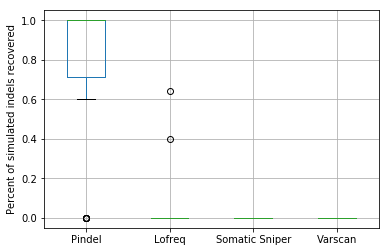

In [25]:
df_indels_sim[['pct_pindel_recovered','pct_lofreq_recovered','pct_somaticSniper_recovered','pct_varscan_recovered']].boxplot()
plt.xticks([1, 2, 3, 4], ['Pindel', 'Lofreq', 'Somatic Sniper','Varscan'])
plt.ylabel('Percent of simulated indels recovered')

In [26]:
df_indels

,BP,INDEL,LOC,SIMULATED,Pindel,Lofreq,SomaticSniper,Varscan,pct_pindel_recovered,pct_lofreq_recovered,pct_somaticSniper_recovered,pct_varscan_recovered
0,1,D,72929595,0,0,0,0,0,0.000000,0.000000,0.0,0.0
1,1,D,72933101,0,6,0,0,0,0.000000,0.000000,0.0,0.0
2,1,D,72933530,0,6,0,0,0,0.000000,0.000000,0.0,0.0
3,1,D,72933648,0,9,0,0,0,0.000000,0.000000,0.0,0.0
4,1,D,72933866,1,0,0,0,0,0.000000,0.000000,0.0,0.0
5,1,D,72933867,4,3,0,0,0,0.750000,0.000000,0.0,0.0
6,1,D,72934297,0,5,0,0,0,0.000000,0.000000,0.0,0.0
7,1,D,72934856,0,6,0,0,0,0.000000,0.000000,0.0,0.0
8,1,D,72936926,0,0,0,0,28,0.000000,0.000000,0.0,0.0
9,1,D,72937906,0,0,1,0,0,0.000000,0.000000,0.0,0.0
